## Running hyperparameter optimization - Part 2

This notebook goes through part two of the steps and codes for identifying the optimal hyperparameter settings for the Variational Autoencoder framework for integrating multi-omics and clinical data spanning both categorical and continuous variables. <br>

The optimal settings are identified based on multiple steps cosidering both reconstruction on the test and training sets as well as the stability/similiarity of the latent space in case of repeated training. Part one focus on the test and training reconstruction accuracies using in <i>MOVE_hyperparameter_optimization_reconstruction.ipynb</i>. From those results the optimal combination are then tested for stability of the latent space in repeated training using this notebook.

In [1]:
#!pip uninstall umap


Below are the funcitons for reading data and calculations defiend

The next part is for reading in the data. This example uses the different datatypes included in the publication of MOVE which consist of three categorical datatypes and seven continuous. NOTE the data is not availble for testing. 

For this part we use all the data contraty to part 1 where it was divided into trainig and test, and investigate how similar the latent space is between the repeated runs. Below we define the selected hyper-parameter settings with equal or close to equal performance based on part 1. For plotting purposes we only test on three different "types" here being size of the hidden layer (nHidden), size of the latent space (nLatents) and the drop-out (drop_outs). The number of hidden lasyers are set to 1 (nl=1). We here repeat the traininng 5 times. 

In [2]:
from hydra import initialize, initialize_config_module, initialize_config_dir, compose

from move._utils.data_utils import get_data, get_list_value
from move._utils.visualization_utils import draw_boxplot
from move._training.train import optimize_stability
from move._analysis.analysis import get_top10_stability, calculate_latent

/home/valentas/move2/MOVE/src/move/training/train.py:16: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  @hydra.main(config_path="../conf", config_name="main")


[1e-05]
[500]+20, Drop-out:0.1
	Epoch: 1	Loss: 12.541413	CE: 3.6776896	SSE: 8.863724	KLD: 0.0000	Batchsize: 10
	Epoch: 2	Loss: 11.810916	CE: 3.5878327	SSE: 8.223083	KLD: 0.0000	Batchsize: 10
	Epoch: 3	Loss: 11.454431	CE: 3.5403749	SSE: 7.914056	KLD: 0.0000	Batchsize: 10
	Epoch: 4	Loss: 11.250363	CE: 3.5034359	SSE: 7.746927	KLD: 0.0000	Batchsize: 10
====> Test set loss: 10.8668
[500]+20, Drop-out:0.1
	Epoch: 1	Loss: 12.512689	CE: 3.6706693	SSE: 8.842020	KLD: 0.0000	Batchsize: 10
	Epoch: 2	Loss: 11.812076	CE: 3.5925550	SSE: 8.219521	KLD: 0.0000	Batchsize: 10
	Epoch: 3	Loss: 11.459837	CE: 3.5452443	SSE: 7.914593	KLD: 0.0000	Batchsize: 10
	Epoch: 4	Loss: 11.245916	CE: 3.5045682	SSE: 7.741348	KLD: 0.0000	Batchsize: 10
====> Test set loss: 10.8883
[500]+20, Drop-out:0.1
0
1


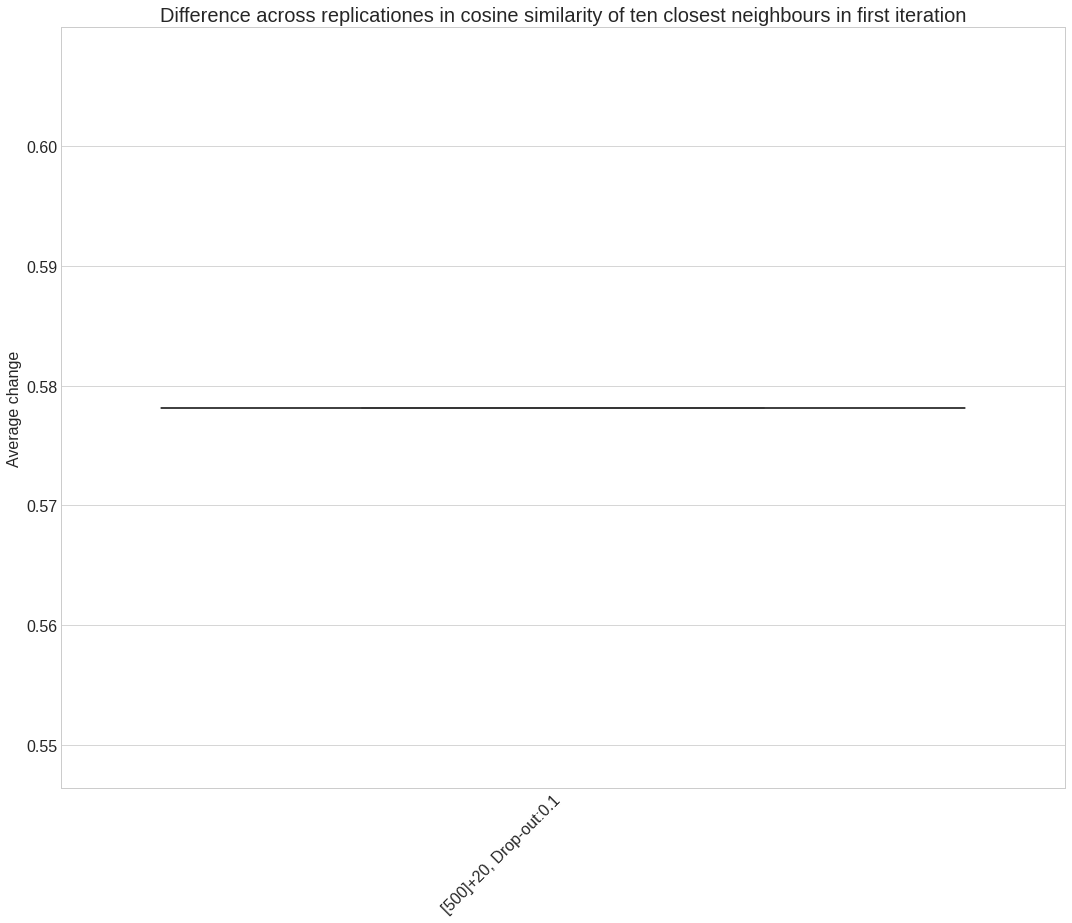

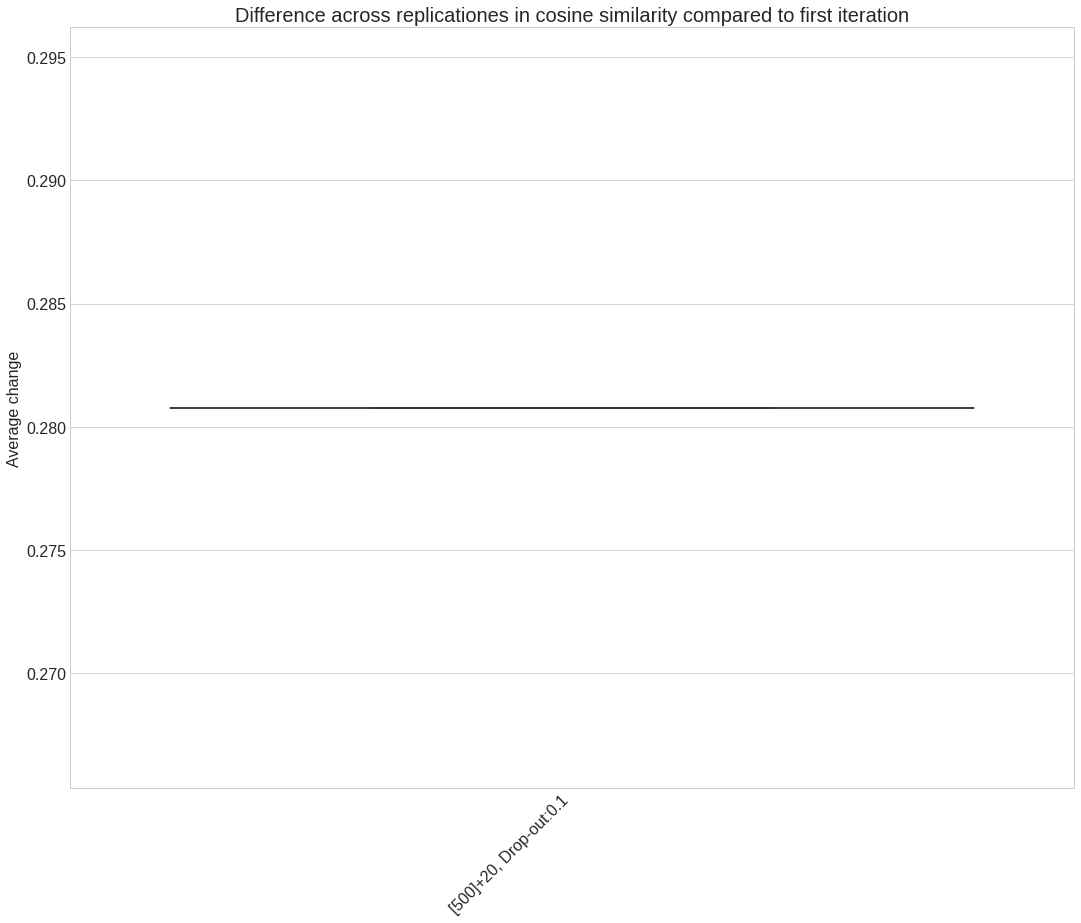

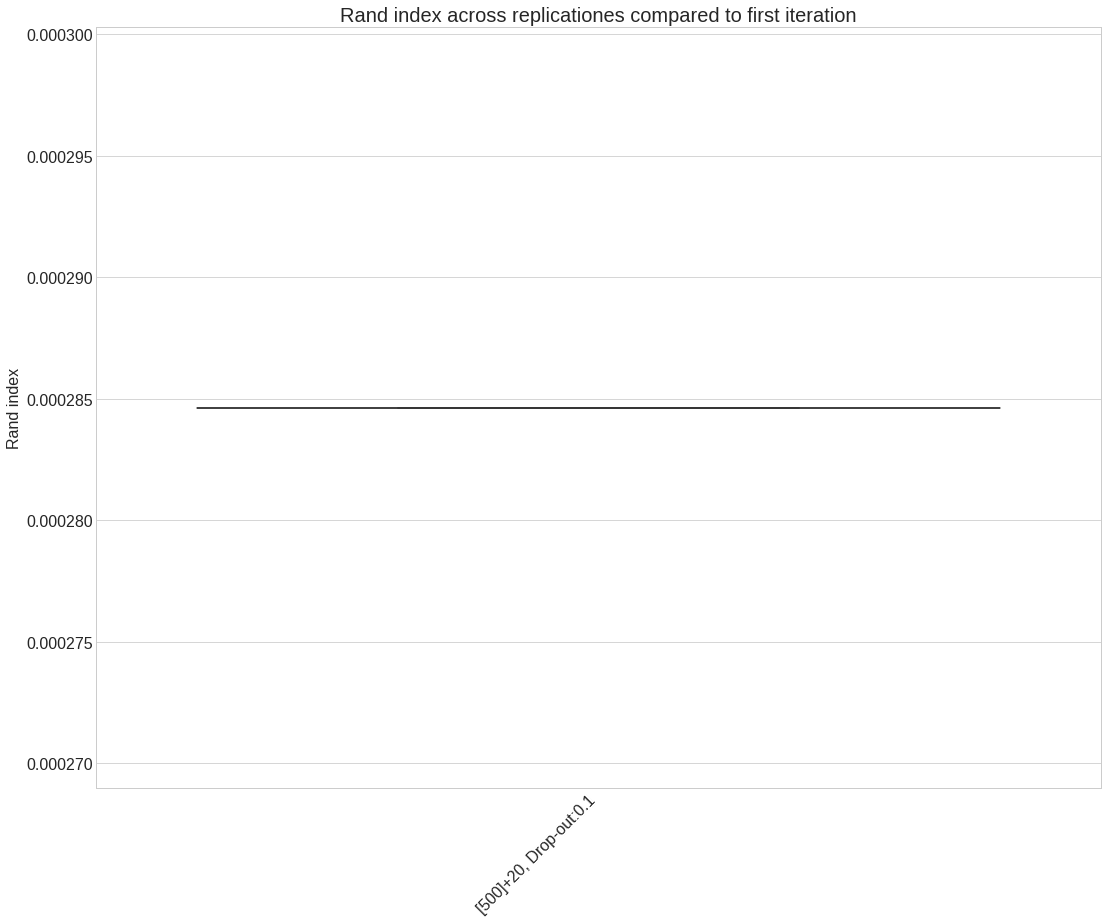

In [3]:
with initialize(version_base=None, config_path="src/move/conf"):
    config = compose(config_name="main")
    
def main(config=config): 
    #Get needed variables
    cuda = config.training.cuda
    path = config.data.processed_data_path
    nHiddens = config.tuning_stability.nHiddens
    nLatents = config.tuning_stability.nLatents
    nLayers = config.tuning_stability.nLayers
    nDropout = config.tuning_stability.nDropout
    nBeta = config.tuning_stability.nBeta
    batch_sizes = config.tuning_stability.batch_sizes
    nepochs = config.training.num_epochs
    repeat = config.training.repeat
    lrate = config.training.lr
    kld_steps = config.training.kld_steps
    batch_steps = config.training.batch_steps
    patience = config.training.patience
    path = config.data.processed_data_path
    categorical_names = config.model.categorical_names
    continuous_names = config.model.continuous_names
    data_of_interest = config.data.data_of_interest
    
    nLayers, batch_sizes = get_list_value(nLayers, batch_sizes)
    print(nBeta)
    if len(nBeta)==1:
        nBeta = nBeta[0]
    
    #Get the data
    cat_list, con_list, cat_names, con_names, headers_all, drug, drug_h = get_data(path, categorical_names, continuous_names, data_of_interest)

    
    embeddings, latents, con_recons, cat_recons, recon_acc = optimize_stability(nHiddens, nLatents, 
                                                                                nDropout, nBeta, repeat,
                                                                                nepochs, nLayers,
                                                                                batch_sizes, lrate, 
                                                                                kld_steps, batch_steps, 
                                                                                cuda, path, 
                                                                                con_list, cat_list)
    
    stability_top10 = get_top10_stability(nHiddens, nLatents, nDropout, repeat, nLayers, latents)
    
    stability_total, rand_index = calculate_latent(nHiddens, nLatents, nDropout, repeat, nLayers, latents) # Todo add priting or smth
    
    draw_boxplot(path=path,
                 df=stability_top10,
                 title_text='Difference across replicationes in cosine similarity of ten closest neighbours in first iteration',
                 y_label_text="Average change",
                 save_fig_name="stability_top10")
    
    
    draw_boxplot(df=stability_total,
                 path=path,
                 title_text='Difference across replicationes in cosine similarity compared to first iteration',
                 y_label_text="Average change",
                 save_fig_name="stability_all")
    
    draw_boxplot(df=rand_index,
                 path=path,
                 title_text='Rand index across replicationes compared to first iteration',
                 y_label_text="Rand index",
                 save_fig_name="rand_index_all")

if __name__ == "__main__":
    main()


Below we run the full grid search. Here we also save the UMAP embeddings for the posibility of a visual investigation of the results.

Below is calcualtion and visualisation only focusig on the top 10 closest neigbour for each individual

The next part compared based on all of the latent space. Furthermore, it includes code for calculation on cluster stability if the latent space is to be used for clustering (not used by MOVE in the paper here only cosine similarity on latent is included).

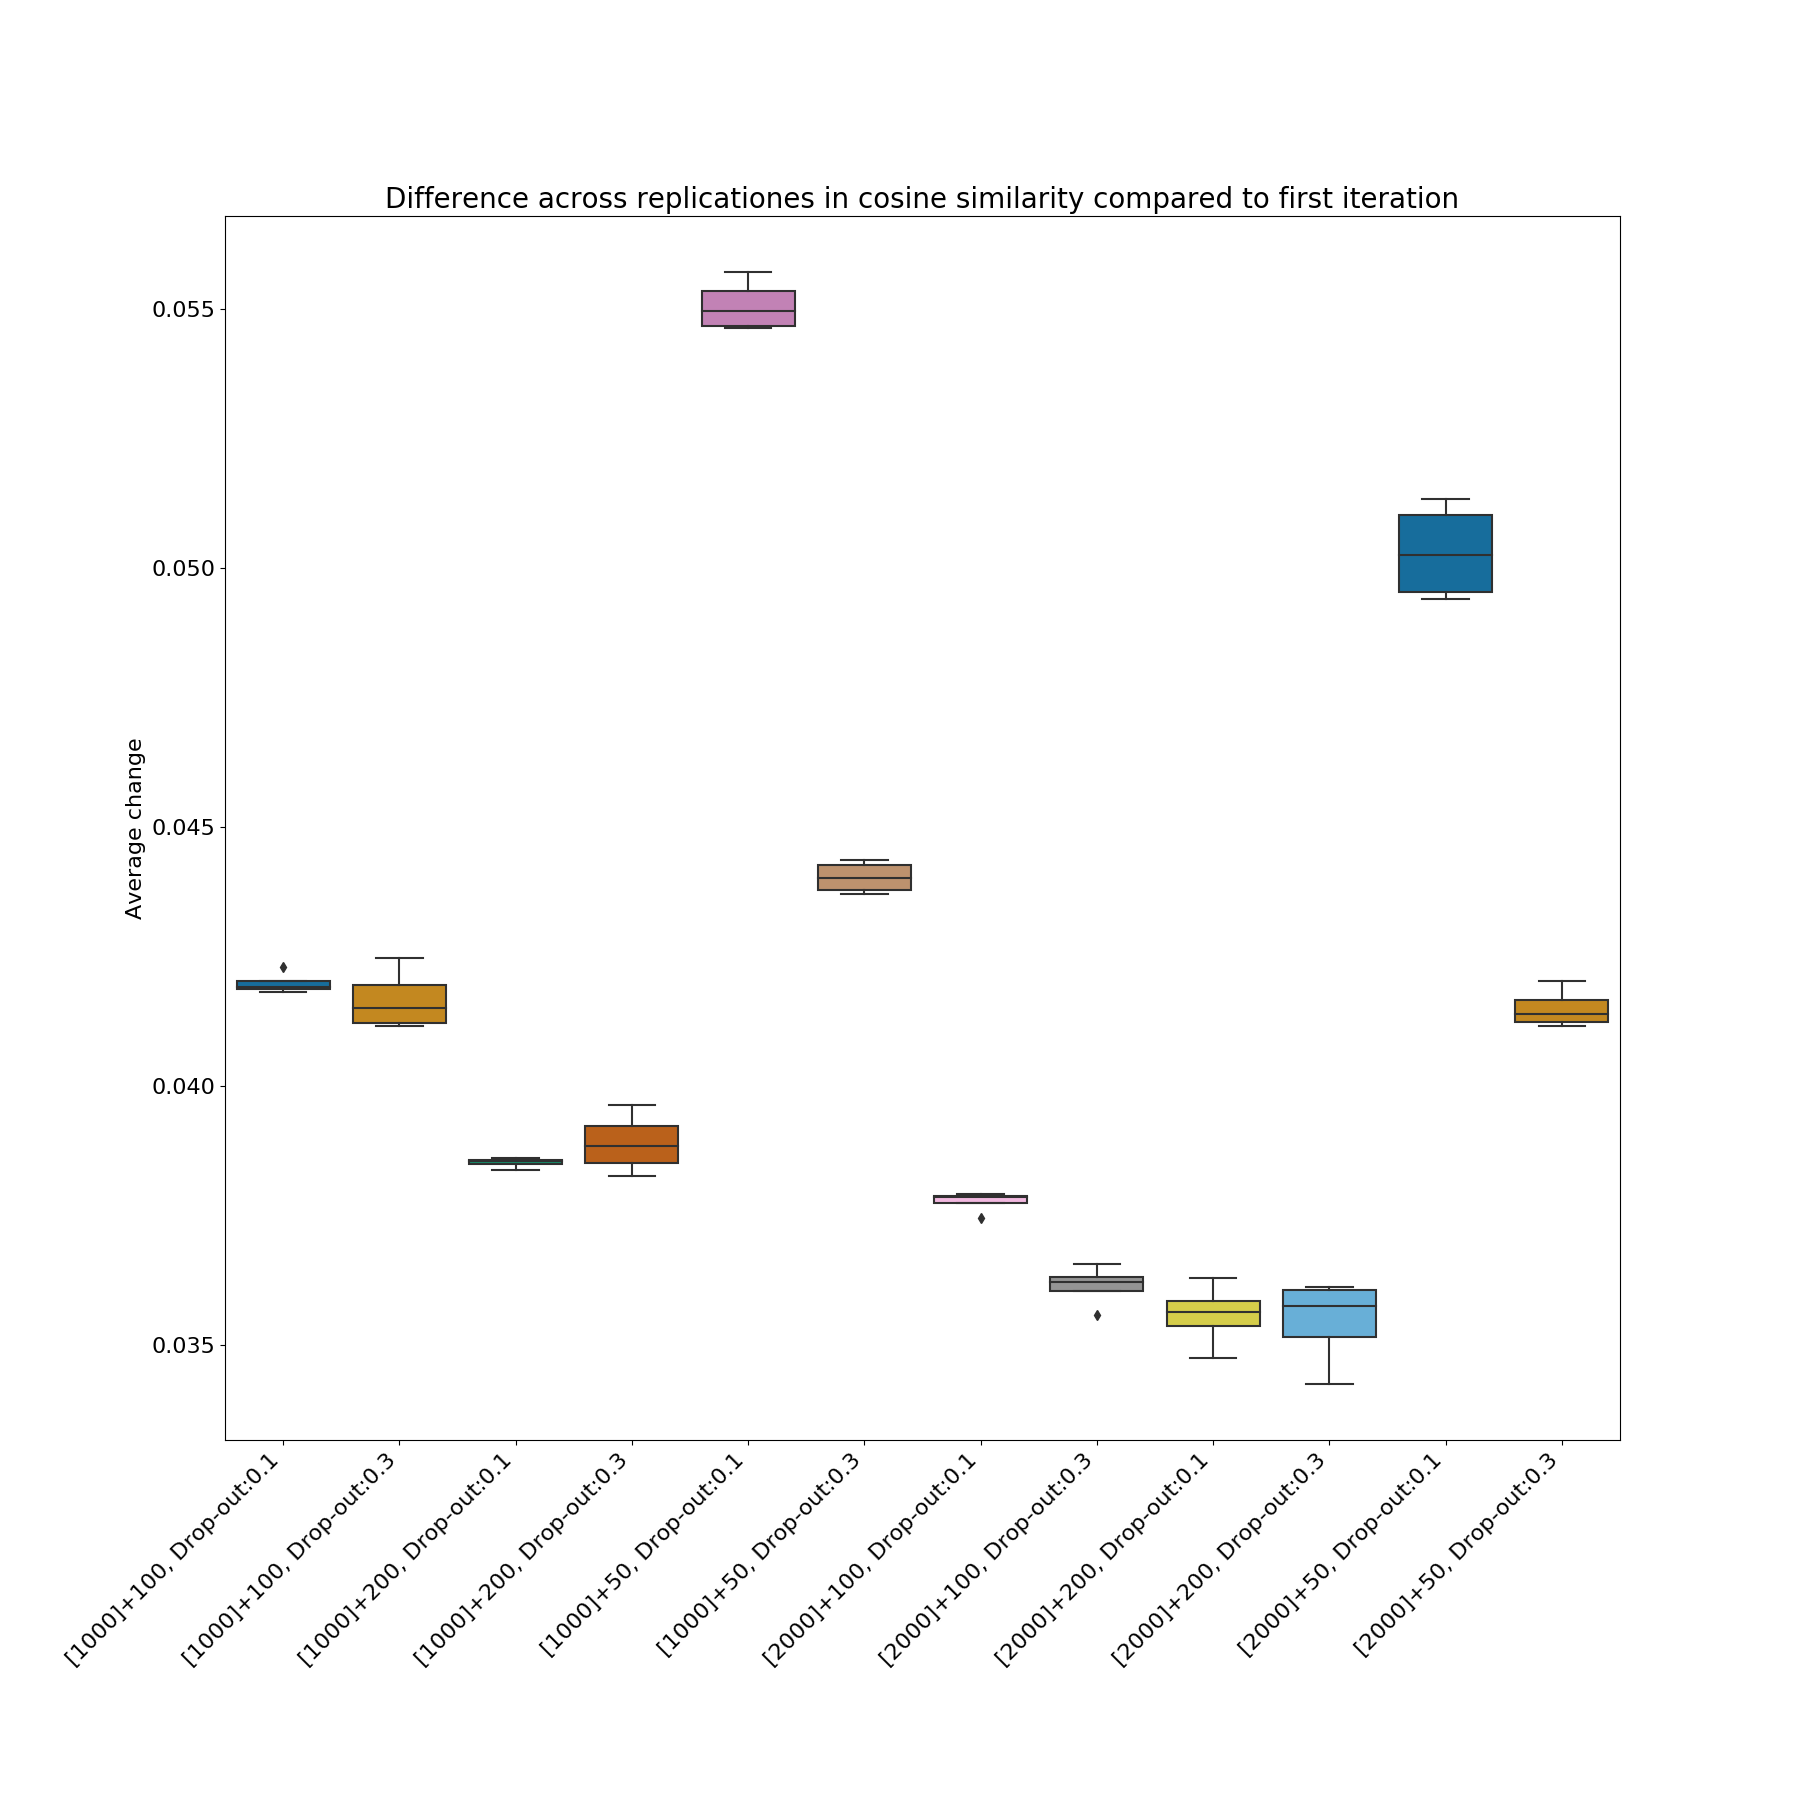

From here on the optimal setting for further analysis can be selected. This includes the framework used in MOVE for identifying drug and multi-omics assosiations as descriped in the notebook <i>identify_drug_assosiation.ipynb</i>, compare the latent space integration to other methods (PCA) using the notebook <i>latent_space_analysis.ipynb</i> or for other types of analysis such as clustering of the latent space (not included here). 